# Alberta Weather Station Clustering & Visualization
This notebook provides a set of functions encapsulated in a class for visualizing weather station data in Alberta from 2007 to 2024.

In [ ]:
# !pip install geopandas shapely
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.cm as cm

In [10]:
class AlbertaStationVisualizer:
    def __init__(self, csv_path):
        self.df = pd.read_csv(csv_path, skiprows=3)
        self.filtered_df = None
        self.kmeans = None
        self.centers = None
        self._prepare_data()

    def _prepare_data(self):
        self.df = self.df[self.df['Province'].str.upper() == 'ALBERTA'].copy()
        self.df.dropna(subset=['Latitude (Decimal Degrees)', 'Longitude (Decimal Degrees)'], inplace=True)
        geometry = [Point(xy) for xy in zip(self.df['Longitude (Decimal Degrees)'], self.df['Latitude (Decimal Degrees)'])]
        self.df = gpd.GeoDataFrame(self.df, geometry=geometry)
        self.filtered_df = self.df[((self.df['First Year'] <= 2024) & (self.df['Last Year'] >= 2007))].copy()

    def plot_filtered_stations(self):
        fig, ax = plt.subplots(figsize=(10, 10))
        self.filtered_df.plot(ax=ax, markersize=10)
        ax.set_xlim([-120, -110])
        ax.set_ylim([48.9, 60.0])
        ax.set_title('Alberta Weather Stations Active (2007–2024)')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        plt.grid(True)
        plt.show()

    def plot_stations_by_mid_year(self):
        df = self.filtered_df.copy()
        df['Mid Year'] = ((df['First Year'] + df['Last Year']) / 2).round().astype(int)
        df['Mid Year'] = df['Mid Year'].clip(lower=2007, upper=2024)
        years = np.arange(2007, 2025)
        colors = cm.get_cmap('tab20', len(years))(np.linspace(0, 1, len(years)))
        year_color_map = dict(zip(years, colors))
        df['Color'] = df['Mid Year'].map(year_color_map)
        fig, ax = plt.subplots(figsize=(12, 10))
        for year in years:
            year_df = df[df['Mid Year'] == year]
            if not year_df.empty:
                year_df.plot(ax=ax, markersize=10, color=year_color_map[year], label=str(year))
        ax.set_xlim([-120, -110])
        ax.set_ylim([48.9, 60.0])
        ax.set_title('Alberta Weather Stations (Colored by Mid-Year Active: 2007–2024)')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.legend(title='Mid Year', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def cluster_stations(self, n_clusters=100):
        coords = self.filtered_df[['Latitude (Decimal Degrees)', 'Longitude (Decimal Degrees)']]
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.filtered_df['Cluster'] = self.kmeans.fit_predict(coords)
        self.centers = self.kmeans.cluster_centers_

    def plot_clusters(self):
        self.cluster_stations()
        fig, ax = plt.subplots(figsize=(12, 10))
        self.filtered_df.plot(ax=ax, column='Cluster', cmap='tab20b', legend=True, markersize=20, alpha=0.8)
        if self.centers is not None:
            ax.scatter(self.centers[:, 1], self.centers[:, 0], c='black', s=40, marker='x', label='Cluster Centers')
        ax.set_xlim([-120, -110])
        ax.set_ylim([48.9, 60.0])
        ax.set_title('Alberta Weather Stations - Clustered into Colored Regions')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

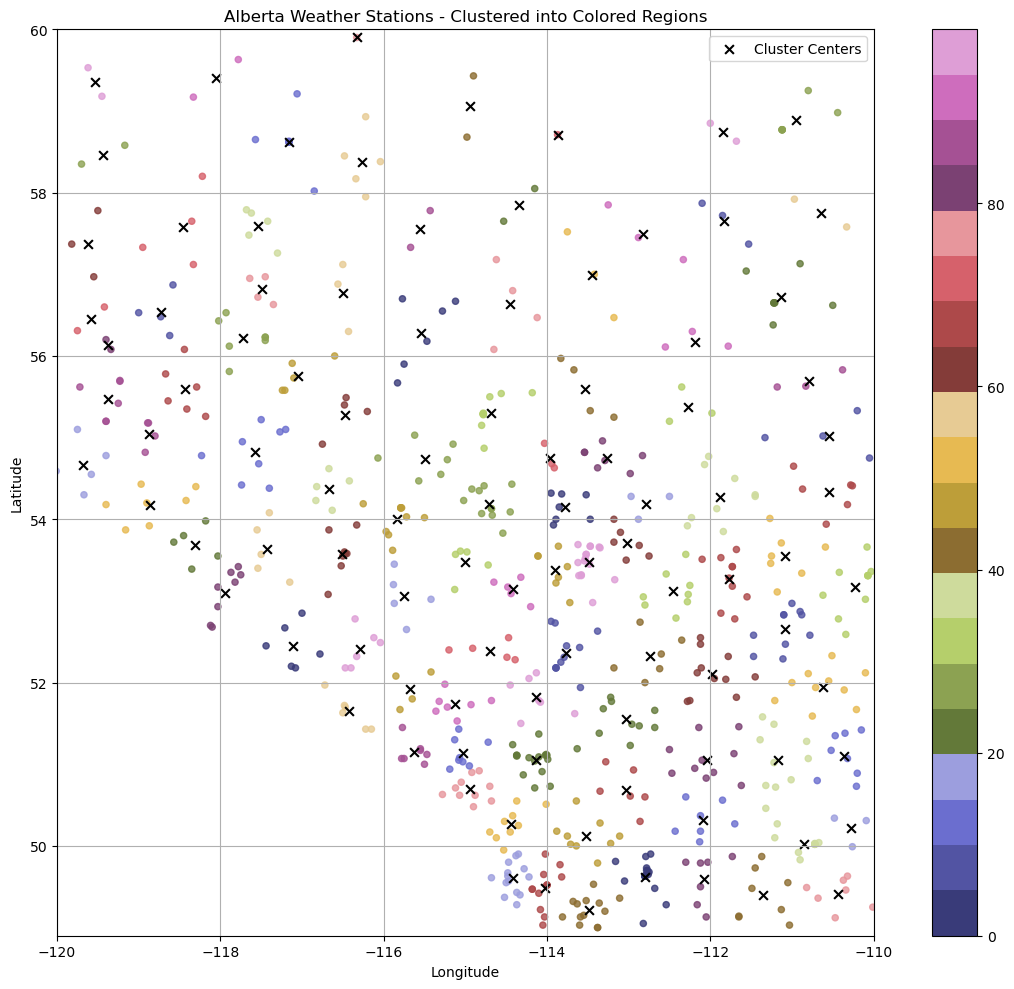

In [11]:
vis = AlbertaStationVisualizer("StationInventoryEN.csv")
vis.plot_clusters()